# Mnist data
* grid search for small data
* split k-fold and plot learning curve


In [1]:
# append path to the library
import sys, os
from os.path import dirname
p = dirname(os.getcwd())
sys.path.append(p)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
from sklearn.externals import joblib

from stochastic_optimizer.estimator import SGDClassifier, AdamClassifier, AdaGradClassifier, RMSpropClassifier
from stochastic_optimizer.estimator import AdaDeltaClassifier, VSGDClassifier
from stochastic_optimizer.framework import LearningCurveClassifier, GridSearch
from stochastic_optimizer.other import PlotCurves

# Simple Mnist
# from sklearn import datasets
# datasets.load_digits().data

# Original Mnist
from sklearn.datasets import fetch_mldata
digits = fetch_mldata('MNIST original', data_home="../data")

X, y = [digits.data, digits.target]

## Grid search
- check the progress at "path/logger.log"
- "path" is the parameter of "GridSearch"

In [24]:
p = {'eta0': np.linspace(0.00005, 0.1, 30), 'power_t': [0.5, 1]}
p_0 = {'eta0': np.linspace(0.00005, 0.1, 30)}
p_1 = {'eta0': np.linspace(0.00005, 0.1, 30), 'var_w': np.linspace(0.01, 1, 20)}
p_2 = {'eps_': [10**i for i in np.linspace(-10, -1, 30)], 'rms':[True, False], 'var_w': np.linspace(0.01, 1, 20)}
# p_3 = {'rms': [True, False], 'var_w': np.linspace(0.1, 1, 20), 'decay':[False, True]}

setting = {'loss': 'log', 'warm_start': True,'n_jobs': 10, "fit_intercept": True}

classifiers = [
    ("SGD", SGDClassifier(**setting), p),
    ("AdaGrad", AdaGradClassifier(**setting), p_0),
    ("RMSprop", RMSpropClassifier(**setting), p_1),
    ("Adam", AdamClassifier(**setting), p_1),
    ("AdaDelta", AdaDeltaClassifier(**setting), p_2),
#     ("VSGD", VSGDClassifier(**setting), p_3),
]

X_s, y_s = X[0:10000, :], y[0:10000]
path_gs = GridSearch(X_s, y_s, classifiers, path='examples_result/grid_search/',
                     key="classifier_gridsearching", scoring="accuracy")
print("result was saved: %s" % path_gs)

result was saved: examples_result/grid_search/classifier_gridsearching


In [25]:
path_gs = "examples_result/grid_search/classifier_gridsearching"
file = glob.glob("%s/*.pkl" % path_gs)
best_parameter = {}
for f in file:
    clf = joblib.load(f)    
    name = f.split("/")[-1].replace(".pkl", "")
    best_parameter[name] = clf.best_estimator_.get_params()
best_parameter

{'AdaDelta': {'alpha': 0.0001,
  'eps_': 6.2101694189156166e-08,
  'fit_intercept': True,
  'loss': 'log',
  'momentum': 1,
  'n_jobs': 10,
  'penalty': 'l1',
  'rms': True,
  'var_w': 0.47894736842105268,
  'warm_start': True},
 'AdaGrad': {'alpha': 0.0001,
  'eps_': 1e-08,
  'eta0': 0.048301724137931039,
  'fit_intercept': True,
  'loss': 'log',
  'momentum': 1,
  'n_jobs': 10,
  'penalty': 'l1',
  'warm_start': True},
 'Adam': {'alpha': 0.0001,
  'eps_': 1e-08,
  'eta0': 0.017282758620689658,
  'fit_intercept': True,
  'loss': 'log',
  'momentum': 1,
  'n_jobs': 10,
  'penalty': 'l1',
  'rms': True,
  'var_w': 0.11421052631578947,
  'warm_start': True},
 'RMSprop': {'alpha': 0.0001,
  'eps_': 1e-08,
  'eta0': 0.013836206896551725,
  'fit_intercept': True,
  'loss': 'log',
  'momentum': 1,
  'n_jobs': 10,
  'penalty': 'l1',
  'rms': True,
  'var_w': 0.27052631578947373,
  'warm_start': True},
 'SGD': {'alpha': 0.0001,
  'eta0': 5.0000000000000002e-05,
  'fit_intercept': True,
  'loss

## Learning Models
- check the progress at "path/logger.log"
- "path" is the parameter of "LearningCurveClassifier"

In [26]:
setting = {'loss': 'log', 'warm_start': True,'n_jobs': 10, "fit_intercept": True}
classifiers = [
    ("SGD", SGDClassifier(**setting)),
    ("VSGD", VSGDClassifier(**setting)),# best_parameter["VSGD"])),
    ("AdaGrad", AdaGradClassifier(**best_parameter["AdaGrad"])),
    ("RMSprop", RMSpropClassifier(**best_parameter["RMSprop"])),
    ("Adam", AdamClassifier(**best_parameter["Adam"])),
    ("AdaDelta", AdaDeltaClassifier(**best_parameter["AdaDelta"])),
]
path_lc = LearningCurveClassifier(X, y, classifiers, rounds=2,
                        split=100, path='examples_result/compare/', key="classification_simulation")

## Plot Learning Curve

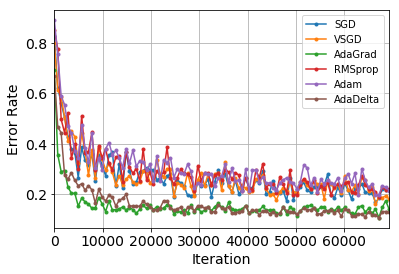

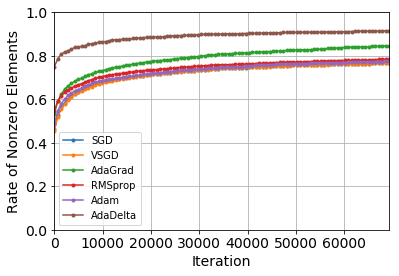

In [28]:
with open("%s/simulation_setting.json" % path_lc) as f:
    params = json.load(f)
with open("%s/error.json" % path_lc) as f:
    error = json.load(f)
with open("%s/nonzero.json" % path_lc) as f:
    nonzero = json.load(f)
    
pc = PlotCurves(**params) #, remove=["VSGD", "AdaGrad", "AdaDelta", "Adam"])

fig = pc.error(error, fill_ci=False)
plt.rcParams['font.size'] = 14
plt.legend(loc="best", fontsize=10)
plt.savefig("%s/error.eps" % path_lc, bbox_inches="tight")
plt.savefig("%s/error.pdf" % path_lc, bbox_inches="tight", transparent=True)
plt.show()

fig = pc.sparsity(nonzero, fill_ci=False)
plt.rcParams['font.size'] = 14
plt.legend(loc="best", fontsize=10)
plt.savefig("%s/sparsity.eps" % path_lc, bbox_inches="tight")
plt.savefig("%s/sparsity.pdf" % path_lc, bbox_inches="tight", transparent=True)
plt.show()